## Feature Selection

Feature Selection hat zum Ziel redundante und irrelevante Attribute zu eliminieren.

Feature Selection Methoden lassen sich in drei Gruppen einordnen (s.h. Feature_Selection Methodenübersicht.png):
* Filter
* Wrapper
* Eingebettete Methoden

Wir eliminieren zunächst redundante Attribute durch Heatmaps auf Basis von Korrelationsmetriken. Zur Idenfifikation von irrelevanten Attributen benutzen wir den Relief Filter-Algorithmus, der die Vorteile von Filtern und Wrappern in Einklang bringt. Im Anschluss überprüfen wir, ob die identifizierten Attribute tatsächlich keine Verbesserung der Modellperformance nach sich ziehen.

In [1]:
#from skrebate import ReliefF
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import csv

#from sklearn.metrics import matthews_corrcoef
#from scipy.stats import spearmanr
#from scipy.stats import pearsonr
#from scipy.stats import chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#import category_encoders as ce
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go

### Run Data Preparation and Feature Engineering

In [59]:
%run FeatureEngineering.ipynb
df.to_hdf('preprocessed_data.h5', key='df', mode='w')
x_train.to_hdf('preprocessed_data.h5', key='x_train')
x_test.to_hdf('preprocessed_data.h5', key='x_test')
y_train.to_hdf('preprocessed_data.h5', key='y_train')
y_test.to_hdf('preprocessed_data.h5', key='y_test')

In [2]:
df = pd.read_hdf('preprocessed_data.h5', 'df')
x_train = pd.read_hdf('preprocessed_data.h5', 'x_train')
x_test = pd.read_hdf('preprocessed_data.h5', 'x_test')
y_train = pd.read_hdf('preprocessed_data.h5', 'y_train')
y_test = pd.read_hdf('preprocessed_data.h5', 'y_test')

In [3]:
features_to_remove = ['CUSTOMER_USER_AVERAGE_PRICE', 'CUSTOMER_USER_AVERAGE_SPREAD',
       'CUSTOMER_USER_AVERAGE_TRADE_PRICE',
       'CUSTOMER_USER_AVERAGE_TRADE_SPREAD', 'CUSTOMER_COMPANY_AVERAGE_PRICE',
       'CUSTOMER_COMPANY_AVERAGE_SPREAD',
       'CUSTOMER_COMPANY_AVERAGE_TRADE_PRICE',
       'CUSTOMER_COMPANY_AVERAGE_TRADE_SPREAD']

x_train.drop(features_to_remove, axis=1, inplace=True)

In [4]:
metric_features = ['QUOTE_PRICE_ASK', 'SPREAD', 'COUPON', 'MATURITY_REMAINING', 'QUANTITY1', 'MID', 'PRICE','INTERBANK_POINTS','SALES_FEE']

ordinal_features=['BOND_RATING_MOODYS','COMPETITION_COUNT']

categorical_features =  ['CUSTOMER_USER', 'CUSTOMER_USER_ID', 'CUSTOMER_COMPANY', 'CUSTOMER_COMPANY_ID', 'CUSTOMER_GROUP','CUSTOMER_CLASSIFICATION',
                       'INSTRUMENT_IDENTIFIER', 'INSTRUMENT_GROUP_ID', 'INSTRUMENT_BOOK', 'MARKET_NAME','NOTIONAL_CURRENCY', 'SALES_GROUP', 'SALES_USER', 
                       'SECTOR','CUSTOMER_SUBACCOUNT_ID', 'CUSTOMER_COUNTRY', 'POPUP_REASON_EXISTS']

binary_features = ['POPUP_QUOTE_REFLEX_STATUS', 'POPUP_QUOTE_SIZE_EXCEEDED','POPUP_LIMIT_EXCEEDED', 'AXE_WAS_ACTIVE', 'LIQUID', 'SI','IS_CONSULTANCY',]

y='TRADE'

### Identify Redundant Features

In [3]:
def cramers_corrected_stat(df):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(df.iloc[:,0], df.iloc[:,1])
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [4]:
def get_correlation_matrix(df,binary, categorial, ordinal, metric):
    num_samples, num_features = df.shape
    sample_rate = 0.3
    correlation_matrix = [[0 for i in range(num_features)] for j in range(num_features)]
    
    for i in range(num_features):
        for j in range(num_features-i):
            j = j+i
            if i==j:
                correlation_matrix[i][j] = 1
            elif (df.columns[i] in categorial_features or df.columns[j] in categorial_features):
                correlation_matrix[i][j] = cramers_corrected_stat(df.iloc[:,[i,j]].sample(frac=sample_rate))
            elif (df.columns[i] in binary and df.columns[j] in binary):
                correlation_matrix[i][j] = matthews_corrcoef(df.iloc[:,i],df.iloc[:,j])
            elif (df.columns[i] in binary or df.columns[j] in binary):
                correlation_matrix[i][j] = cramers_corrected_stat(df.iloc[:,[i,j]].sample(frac=sample_rate))
            elif (df.columns[i] in ordinal or df.columns[j] in ordinal):
                correlation_matrix[i][j] = spearmanr(df.iloc[:,i],df.iloc[:,j])[0]
            else:
                correlation_matrix[i][j] = pearsonr(df.iloc[:,i],df.iloc[:,j])[0]
    
    return correlation_matrix

In [5]:
correlation_matrix = get_correlation_matrix(df,binary_features, categorial_features, ordinal_features, metric_features)

C:\Users\User\.conda\envs\tradepredictor\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\User\.conda\envs\tradepredictor\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [15]:
num_samples, num_features = df.shape
for i in range(num_features):
        for j in range(num_features-i):
            j = j+i
            correlation_matrix [j][i] = correlation_matrix [i][j]

In [3]:
with open("correlations.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(correlation_matrix)

NameError: name 'correlation_matrix' is not defined

In [5]:
correlation_matrix = list(csv.reader(open('correlations.csv'),quoting=csv.QUOTE_NONNUMERIC))

In [58]:
keys=list(df.columns[:-14])
correlation_dict = dict(zip(keys, zip(*correlation_matrix)))
attributes_without_strong_correlations = []
for key, value in correlation_dict.items():
    contains_strong_correlation = 0
    for v in value:
        if (v<1 and v>0.75):
            contains_strong_correlation = 1
    if (not contains_strong_correlation):
        attributes_without_strong_correlations.append(key)

removed_indices = []
resulting_keys=keys.copy()
for k in attributes_without_strong_correlations:
    removed_indices.append(keys.index(k))
    correlation_dict.pop(k, None)
    resulting_keys.remove(k)

for key,value in correlation_dict.items():
    value = list(value)
    value = [i for j, i in enumerate(value) if j not in removed_indices]
    correlation_dict[key]=value

    
relevant_correlation_matrix = list(correlation_dict.values())

<AxesSubplot:>

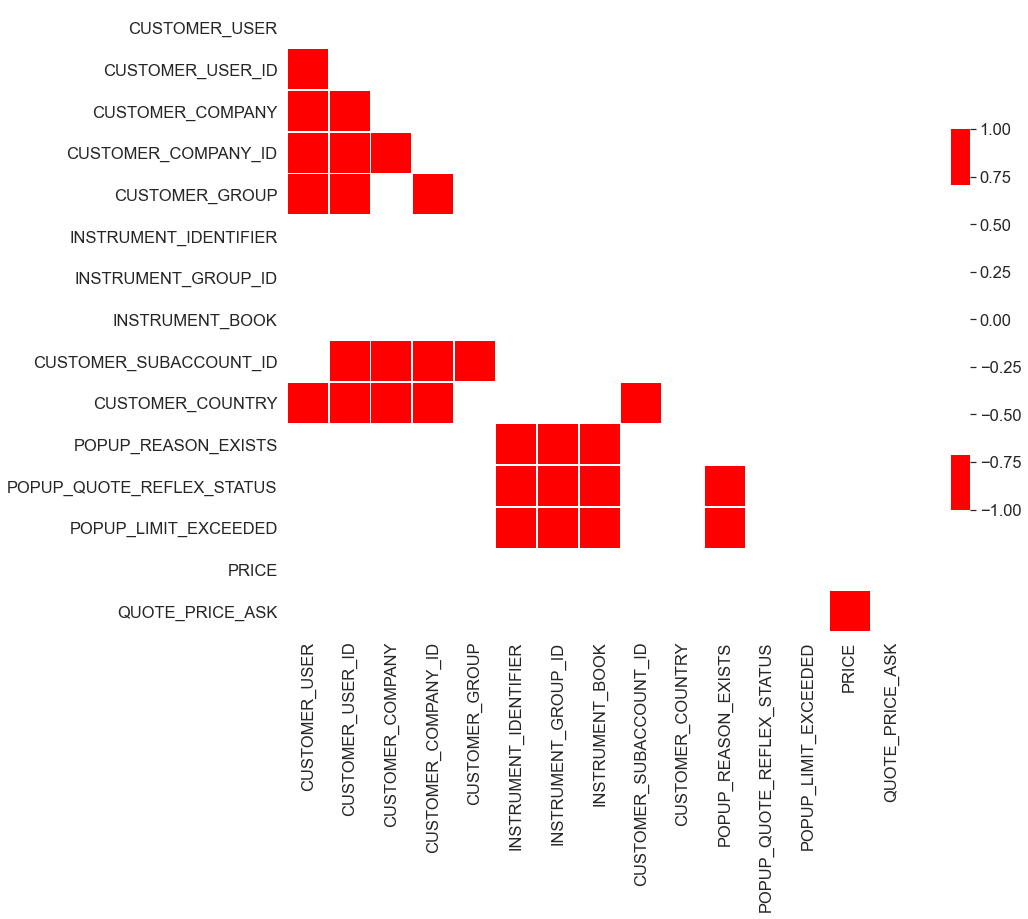

In [59]:
sns.set_theme(style="white", font_scale=1.5)
mask = np.triu(np.ones_like(relevant_correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(14, 14))
correlation_heatmap = sns.heatmap(relevant_correlation_matrix, mask=mask, cmap=ListedColormap(['red', 'white','white','white','white','white' , 'red']), vmax=1,vmin=-1, center=0,
            xticklabels=resulting_keys,yticklabels=resulting_keys,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plot = correlation_heatmap.get_figure()
correlation_heatmap
plot.savefig("Pictures/correlation_heatmap_threshold_shrinked.png",bbox_inches='tight')

In [20]:
keys=df.columns[:-14]
correlation_dict = dict(zip(keys, zip(*correlation_matrix)))
for key, value in correlation_dict.items():
    index = 0
    features = []
    for v in value:
        if (v > 0.75 or v < -0.75):
            v = df.columns[:-14][index]
            if (v!=key):
                features.append(v)
        index +=1
    if (features):
        correlation_dict[key] = features
    else : 
        correlation_dict[key]=None
        
correlation_dict = {k: v for k, v in correlation_dict.items() if v is not None}

fig = go.Figure(data=[go.Table(header=dict(values=['Metrik', 'Alle', 'Relevant', 'Redunanzfrei', 'Beides']),
                 cells=dict(values=[['Accuracy','Precision','Recall'],results[0], results[1],results[2],results[3]]))])

{'CUSTOMER_USER': ['CUSTOMER_USER_ID',
  'CUSTOMER_COMPANY',
  'CUSTOMER_COMPANY_ID',
  'CUSTOMER_GROUP',
  'CUSTOMER_COUNTRY'],
 'CUSTOMER_USER_ID': ['CUSTOMER_USER',
  'CUSTOMER_COMPANY',
  'CUSTOMER_COMPANY_ID',
  'CUSTOMER_GROUP',
  'CUSTOMER_COUNTRY'],
 'CUSTOMER_COMPANY': ['CUSTOMER_USER',
  'CUSTOMER_USER_ID',
  'CUSTOMER_COMPANY_ID',
  'CUSTOMER_SUBACCOUNT_ID',
  'CUSTOMER_COUNTRY'],
 'CUSTOMER_COMPANY_ID': ['CUSTOMER_USER',
  'CUSTOMER_USER_ID',
  'CUSTOMER_COMPANY',
  'CUSTOMER_SUBACCOUNT_ID',
  'CUSTOMER_COUNTRY'],
 'CUSTOMER_GROUP': ['CUSTOMER_USER', 'CUSTOMER_USER_ID'],
 'INSTRUMENT_IDENTIFIER': ['POPUP_LIMIT_EXCEEDED'],
 'INSTRUMENT_GROUP_ID': ['POPUP_REASON_EXISTS',
  'POPUP_QUOTE_REFLEX_STATUS',
  'POPUP_LIMIT_EXCEEDED'],
 'INSTRUMENT_BOOK': ['POPUP_REASON_EXISTS',
  'POPUP_QUOTE_REFLEX_STATUS',
  'POPUP_LIMIT_EXCEEDED'],
 'CUSTOMER_SUBACCOUNT_ID': ['CUSTOMER_COMPANY',
  'CUSTOMER_COMPANY_ID',
  'CUSTOMER_COUNTRY'],
 'CUSTOMER_COUNTRY': ['CUSTOMER_USER',
  'CUSTOMER_USE

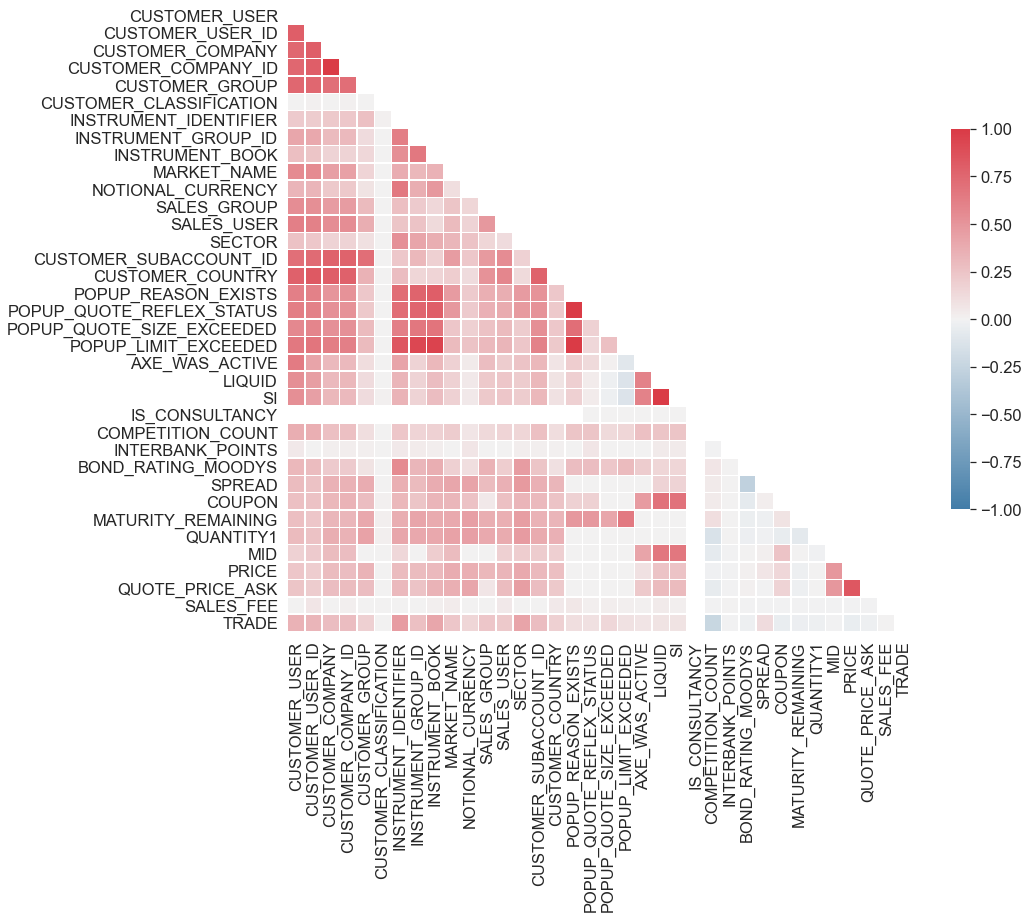

In [15]:
sns.set_theme(style="white",font_scale=1.5)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(14, 14))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
correlation_heatmap = sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            xticklabels=df.columns[:-14],yticklabels=df.columns[:-14],
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plot = correlation_heatmap.get_figure()
plot.savefig("Pictures/correlation_heatmap.png",bbox_inches='tight')

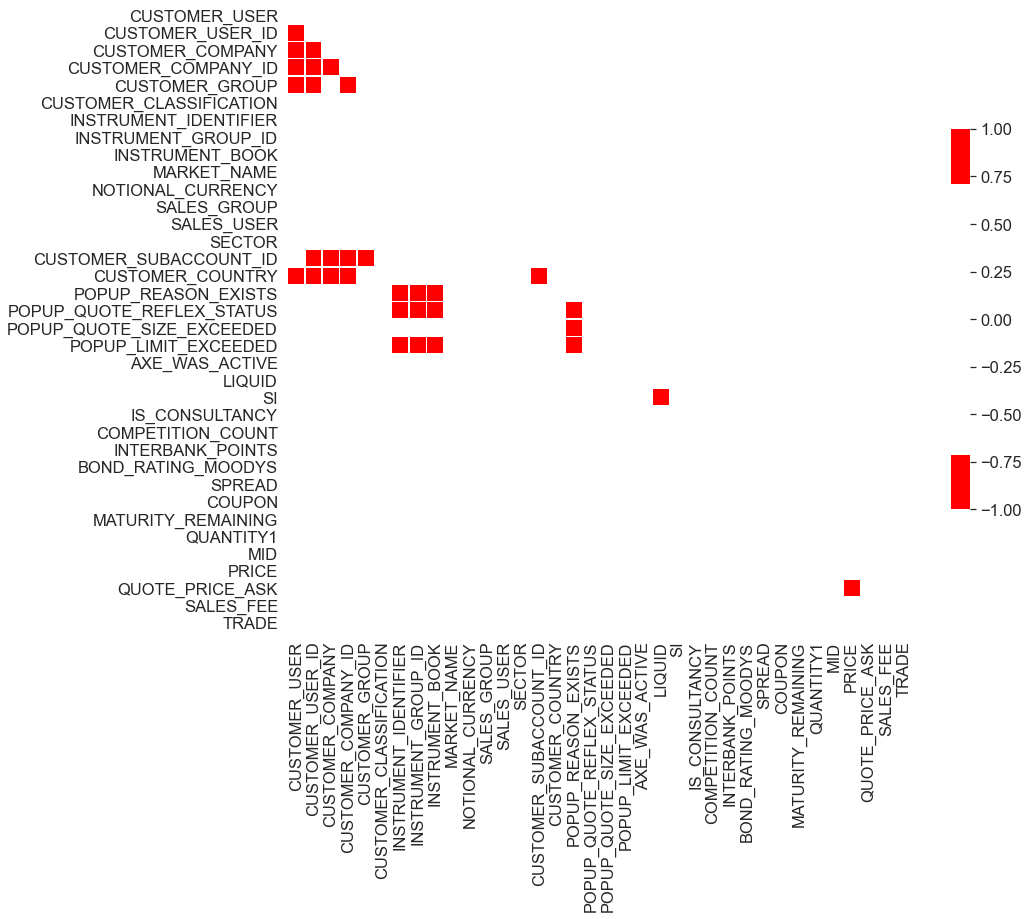

In [17]:
sns.set_theme(style="white", font_scale=1.5)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(14, 14))
correlation_heatmap = sns.heatmap(correlation_matrix, mask=mask, cmap=ListedColormap(['red', 'white','white','white','white','white' , 'red']), vmax=1,vmin=-1, center=0,
            xticklabels=df.columns[:-14],yticklabels=df.columns[:-14],
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plot = correlation_heatmap.get_figure()
correlation_heatmap
plot.savefig("Pictures/correlation_heatmap_threshold.png",bbox_inches='tight')

In [50]:
# Select indices of strong correlating features, e.g. values > 0.75 or <-0.75 

correlation_matrix = np.array(correlation_matrix) # transform to numpy
strong_correlations_raw = np.argwhere((correlation_matrix<1) & (correlation_matrix >0.75))
num_indices = len(np.unique([i[0] for i in strong_correlations_raw]))
strong_correlations = {}

for i,j in strong_correlations_raw:
    if (i in strong_correlations):
        strong_correlations[i].append(j)
    else :
        strong_correlations[i] = [j]

In [52]:
# select redundant features among strongly dependend features 

redundant_feature_indices = []
empty_keys = []
while bool(strong_correlations):
    
    # attribute with most dependencies
    strongest_feature_idx = max(strong_correlations, key=lambda x:len(strong_correlations[x])) 
    
    # iterate over dependencies
    for j in strong_correlations[strongest_feature_idx]:
        # remove dependent feature from keys 
        strong_correlations.pop(j, None)
        # remove dependent feature from values
        for key, value in strong_correlations.items(): 
            if (j in value):
                value.remove(j)
                if not strong_correlations[key]:
                        empty_keys.append(key)
        
        # clean up empty arrays
        for k in empty_keys:
            strong_correlations.pop(k, None)
            
        # mark dependent feature as redundant
        redundant_feature_indices.append(j)

# Transform indices to colum names 
redundant_features = list(df.columns[:-14][redundant_feature_indices])

In [53]:
redundant_features

['CUSTOMER_USER_ID',
 'CUSTOMER_COMPANY_ID',
 'CUSTOMER_COUNTRY',
 'INSTRUMENT_GROUP_ID',
 'POPUP_QUOTE_REFLEX_STATUS',
 'INSTRUMENT_IDENTIFIER',
 'POPUP_REASON_EXISTS',
 'CUSTOMER_COMPANY',
 'CUSTOMER_GROUP',
 'POPUP_LIMIT_EXCEEDED',
 'QUOTE_PRICE_ASK']

### Identify Irrelevant Features

In [4]:
# lowest metric 32770
df[metric_features].nunique()
# highest cat 11288
df[categorial_features].nunique()

CUSTOMER_USER              10722
CUSTOMER_USER_ID            7297
CUSTOMER_COMPANY            1516
CUSTOMER_COMPANY_ID         1516
CUSTOMER_GROUP                24
CUSTOMER_CLASSIFICATION       10
INSTRUMENT_IDENTIFIER      11288
INSTRUMENT_GROUP_ID           19
INSTRUMENT_BOOK              153
MARKET_NAME                   13
NOTIONAL_CURRENCY             13
SALES_GROUP                   60
SALES_USER                   115
SECTOR                        85
CUSTOMER_SUBACCOUNT_ID      2113
CUSTOMER_COUNTRY              26
POPUP_REASON_EXISTS            3
dtype: int64

### ReliefF 

In [16]:
# discrete threshold need to be between metric ft 
# with fewest unique values (32770) and categorial ft
# with most unique values (11288)

# we need to sample from our data, since ReliefF is computational expensive
sample_indices = x_train.sample(frac = 0.05).index
x_sample = x_train.loc[sample_indices].to_numpy()
y_sample = y_train.loc[sample_indices].values


feature_selector = ReliefF(discrete_threshold=15000)
feature_selector.fit(x_sample, y_sample)

ReliefF(discrete_threshold=15000)

In [20]:
# assign its relevance to each attribute
feature_relevance = dict(zip(x_train.columns,feature_selector.feature_importances_))

# select irrelevant features
irrelevant_features = [k for (k,v) in feature_relevance.items() if v <= 0]

# sort features according to relevance
feature_relevance = sorted(feature_relevance.items(), key=lambda x: x[1], reverse=False)
features , values = [i[0] for i in feature_relevance] , [i[1] for i in feature_relevance] 

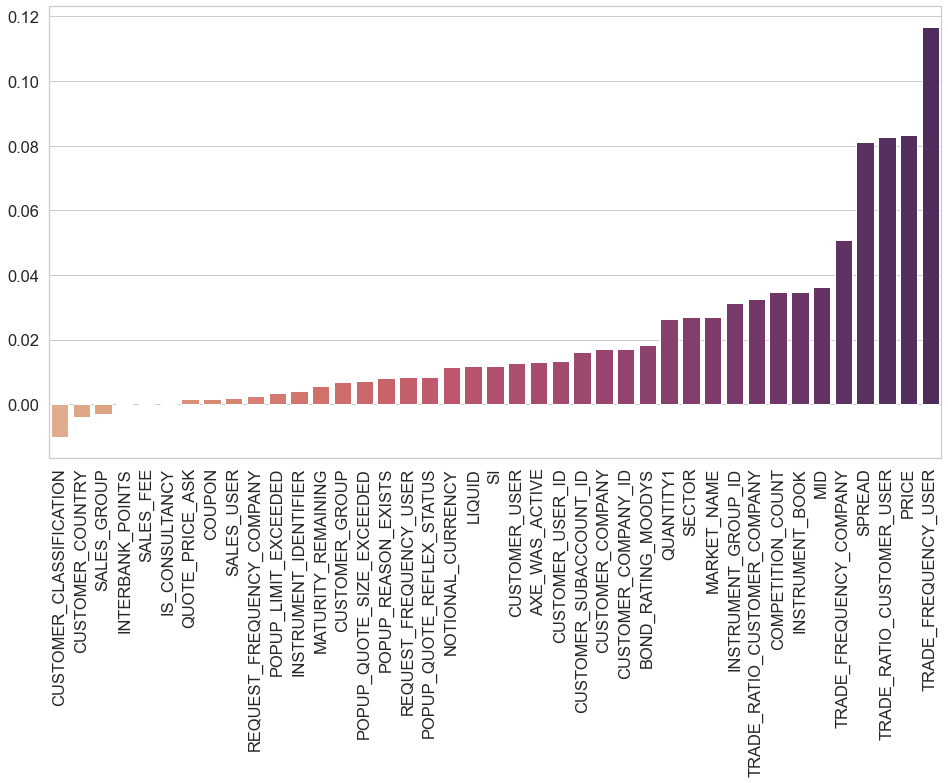

In [9]:
sns.set_theme(style="whitegrid", font_scale=1.5)
plt.subplots(figsize=(16, 8.3))
feature_importances = sns.barplot(x=features, y=values, orient='v', palette='flare')
ticks = plt.xticks(rotation=90)
plot = feature_importances.get_figure()
plot.savefig("Pictures/feature_importances.png",bbox_inches='tight')

In [22]:
irrelevant_features

['CUSTOMER_CLASSIFICATION',
 'SALES_GROUP',
 'CUSTOMER_COUNTRY',
 'IS_CONSULTANCY']

### Evaluation

In [17]:
# encode categorical features with catboost
encoder = ce.CatBoostEncoder(cols=(categorical_features+binary_features+ordinal_features))
encoder.fit(x_train, y_train)
x_train_encoded = encoder.transform(x_train)
x_test_encoded = encoder.transform(x_test)

# we wanna compare 3 cases:
# all attributes
# all attributes - redundant attributes
# all attributes - irrelevant attributes
drop_cases = [[], redundant_features, irrelevant_features, redundant_features+irrelevant_features]

# init result
results = {}
counter = 0

# init random Forest parameters
rf_criterion = 'entropy'
rf_max_depth = 10
rf_n_estimators = 50

# apply subsets to Random Forest
for features_to_remove in drop_cases:
    print(counter)
    x_train_selection = x_train_encoded.drop(features_to_remove, axis = 1)
    x_test_selection = x_test_encoded.drop(features_to_remove, axis = 1)
    
    model = RandomForestClassifier(bootstrap=True,
                                            criterion=rf_criterion,
                                            max_depth=rf_max_depth,
                                            n_estimators=rf_n_estimators,
                                            random_state=None,
                                            verbose=0,
                                            warm_start=False)
    
    # train model and get predictions
    model.fit(x_train_selection, y_train)
    preds_class = model.predict(x_test_selection) 
    
    # eval model and save results
    accuracy = round(accuracy_score(y_test, preds_class),2)
    precision = round(precision_score(y_test, preds_class),2)
    recall = round(recall_score(y_test, preds_class),2)
    results[counter] = [accuracy,precision,recall]
    print(results[counter])
    counter +=1

C:\Users\User\.conda\envs\tradepredictor36\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



0
[0.96, 0.99, 0.93]
1
[0.96, 0.99, 0.92]
2
[0.96, 0.99, 0.93]
3
[0.96, 0.99, 0.92]


In [23]:
fig = go.Figure(data=[go.Table(header=dict(values=['Metrik', 'Alle', 'Relevant', 'Redunanzfrei', 'Beides']),
                 cells=dict(values=[['Accuracy','Precision','Recall'],results[0], results[1],results[2],results[3]]))])
fig.write_image("Pictures/Feature Selection Evaluation.svg")